In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [11]:
## Step 1: Load and Preprocess Data
# Load training and test datasets
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [12]:
# Use closing prices
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

In [13]:
# Normalize the data based on training set only
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [14]:
# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)


In [15]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1199, 60, 1), (1199, 1), (65, 60, 1), (65, 1))

In [16]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [17]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [18]:
## Step 2: Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # RNN layer, batch_first=True means input/output tensors are (batch, seq, feature)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer to output the prediction
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        # h0 shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        # out: (batch_size, seq_length, hidden_size)
        # h_n: (num_layers, batch_size, hidden_size) - final hidden state
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        # We take the output from the last time step (out[:, -1, :])
        out = self.fc(out[:, -1, :])
        return out

In [21]:
model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
!pip install torchinfo

In [23]:
from torchinfo import summary

# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [64, 1]                   --
├─RNN: 1-1                               [64, 60, 50]              7,750
├─Linear: 1-2                            [64, 1]                   51
Total params: 7,801
Trainable params: 7,801
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 29.76
Input size (MB): 0.02
Forward/backward pass size (MB): 1.54
Params size (MB): 0.03
Estimated Total Size (MB): 1.58

In [24]:
criterion = nn.MSELoss() # Mean Squared Error Loss for regression
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

In [25]:
## Step 3: Train the Model

num_epochs = 50 # Define the number of training epochs
train_losses = [] # List to store loss per epoch

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    epoch_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        # Move input and label tensors to the device (CPU/GPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad() # Clear gradients
        loss.backward()       # Compute gradients
        optimizer.step()      # Update model parameters

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

print("Training complete.")

Epoch [1/50], Loss: 0.0699
Epoch [2/50], Loss: 0.0196
Epoch [3/50], Loss: 0.0021
Epoch [4/50], Loss: 0.0008
Epoch [5/50], Loss: 0.0006
Epoch [6/50], Loss: 0.0005
Epoch [7/50], Loss: 0.0005
Epoch [8/50], Loss: 0.0005
Epoch [9/50], Loss: 0.0004
Epoch [10/50], Loss: 0.0004
Epoch [11/50], Loss: 0.0004
Epoch [12/50], Loss: 0.0004
Epoch [13/50], Loss: 0.0004
Epoch [14/50], Loss: 0.0004
Epoch [15/50], Loss: 0.0004
Epoch [16/50], Loss: 0.0003
Epoch [17/50], Loss: 0.0003
Epoch [18/50], Loss: 0.0003
Epoch [19/50], Loss: 0.0003
Epoch [20/50], Loss: 0.0004
Epoch [21/50], Loss: 0.0003
Epoch [22/50], Loss: 0.0003
Epoch [23/50], Loss: 0.0004
Epoch [24/50], Loss: 0.0004
Epoch [25/50], Loss: 0.0003
Epoch [26/50], Loss: 0.0003
Epoch [27/50], Loss: 0.0003
Epoch [28/50], Loss: 0.0003
Epoch [29/50], Loss: 0.0003
Epoch [30/50], Loss: 0.0003
Epoch [31/50], Loss: 0.0003
Epoch [32/50], Loss: 0.0003
Epoch [33/50], Loss: 0.0003
Epoch [34/50], Loss: 0.0003
Epoch [35/50], Loss: 0.0003
Epoch [36/50], Loss: 0.0003
E

Name:            S Rajath
Register Number: 212224240127


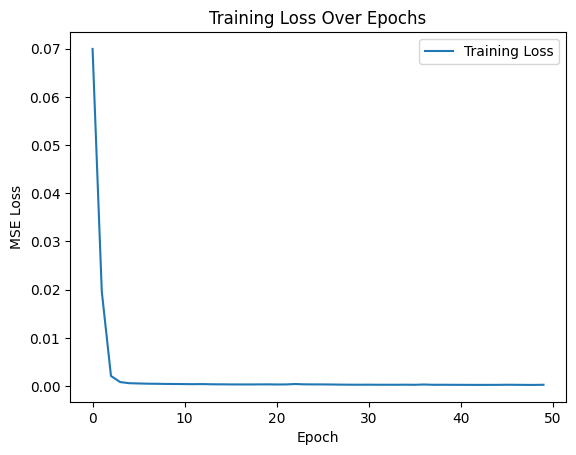

In [28]:
# Plot training loss
print('Name:            S Rajath')
print('Register Number: 212224240127')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


Name:            S Rajath
Register Number: 212224240127


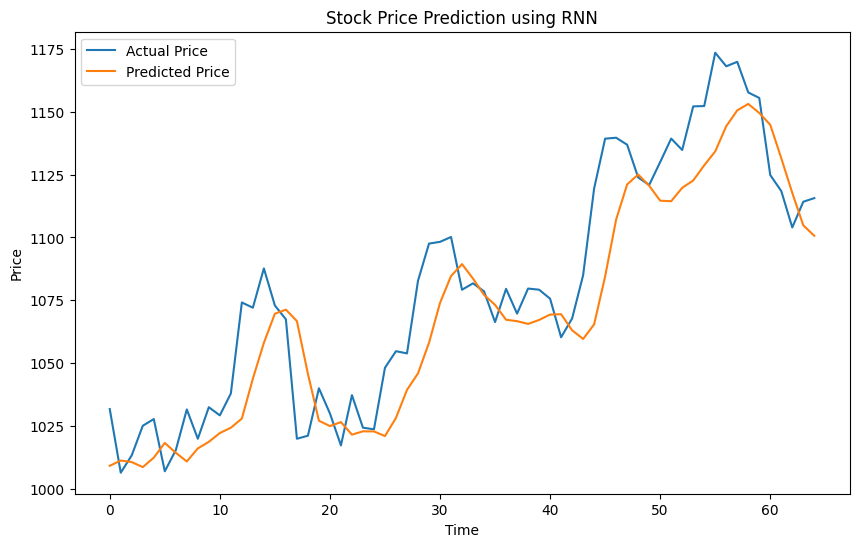

Predicted Price: [1100.6824]
Actual Price: [1115.65]


In [29]:
## Step 4: Make Predictions on Test Set
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Plot the predictions vs actual prices
print('Name:            S Rajath')
print('Register Number: 212224240127')
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')